### Links for Resources

https://www.philschmid.de/fine-tune-llms-in-2024-with-trl

https://www.youtube.com/watch?v=0XPZlR3_GgI

In [1]:
# !pip install tensorboard

In [2]:
# !pip install --upgrade huggingface_hub

### Login to HF with a write token

In [6]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write)

In [ ]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

^C


### Import Dependencies

In [4]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch --progress-bar off #remove version restriction
!pip install -qqq transformers==4.45.1 --progress-bar off
!pip install -qqq datasets==2.20.0 --progress-bar off
!pip install -qqq accelerate==0.31.0 --progress-bar off
!pip install -qqq bitsandbytes==0.43.1 --progress-bar off
!pip install -qqq peft==0.11.1 --progress-bar off
!pip install -qqq trl==0.9.4 --progress-bar off
!pip install -qqq colored==2.2.4 --progress-bar off
!pip install matplotlib seaborn scikit-learn
!pip install accelerate==0.34.2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2024.5.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
  Using cached accelerate-0.34.2-py3-none-any.whl.metadata (19 kB)
Using cached accelerate-0.34.2-py3-none-any.whl (324 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.31.0
    Uninstalling accelerate-0.31.0:
      Successfully uninstalled accelerate-0.31.0


In [1]:
!pip uninstall -y torchvision
!pip install torchvision

Found existing installation: torchvision 0.19.1
Uninstalling torchvision-0.19.1:
  Successfully uninstalled torchvision-0.19.1
  Using cached torchvision-0.19.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.0 kB)
Using cached torchvision-0.19.1-cp310-cp310-manylinux1_x86_64.whl (7.0 MB)


In [2]:
!pip uninstall -y pyarrow
!pip install pyarrow

Found existing installation: pyarrow 17.0.0
Uninstalling pyarrow-17.0.0:
  Successfully uninstalled pyarrow-17.0.0
  Using cached pyarrow-17.0.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
Using cached pyarrow-17.0.0-cp310-cp310-manylinux_2_28_x86_64.whl (39.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


### Check If cuda is available

In [3]:
import torch
torch.cuda.is_available()

True

## Logic

### Imports

In [4]:
import random
from textwrap import dedent
from typing import Dict, List

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from colored import Back, Fore, Style
from datasets import Dataset, load_dataset
from matplotlib.ticker import PercentFormatter
from peft import (
    LoraConfig,
    PeftModel,
    TaskType,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)
from trl import DataCollatorForCompletionOnlyLM, SFTConfig, SFTTrainer

%matplotlib inline
%config InlineBackend.figure_format='retina'

COLORS = ["#bae1ff", "#ffb3ba", "#ffdfba", "#ffffba", "#baffc9"]

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
sns.set_palette(sns.color_palette(COLORS))

cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", COLORS[:2])

MY_STYLE = {
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "axes.linewidth": 0.5,
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.grid": True,
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium",
    "axes.titlesize": "large",
    "axes.labelsize": "large",
    "lines.color": COLORS[0],
    "patch.edgecolor": "white",
}

mpl.rcParams.update(MY_STYLE)

SEED = 42


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(SEED)
PAD_TOKEN = "<|pad|>"
MODEL_NAME = "meta-llama/Llama-3.2-1B-Instruct"
NEW_MODEL = "Llama-3.2-1B-Instruct-Finance-RAG"

In [ ]:
# %reset -f

### load model from HF

In [8]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.add_special_tokens({"pad_token": PAD_TOKEN})
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=quantization_config,
    #     attn_implementation="flash_attention_2",
    #     attn_implementation="sdpa",
    device_map="auto",
    # token='PLACE_TOKEN_HERE'
)
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Embedding(128264, 2048)

In [9]:
model.config

LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": false,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_

### Check Tokenizer information

In [10]:
tokenizer.bos_token, tokenizer.bos_token_id

('<|begin_of_text|>', 128000)

In [11]:
tokenizer.eos_token, tokenizer.eos_token_id

('<|eot_id|>', 128009)

In [12]:
tokenizer.pad_token, tokenizer.pad_token_id

('<|pad|>', 128256)

In [13]:
tokenizer.pad_token, tokenizer.pad_token_id

('<|pad|>', 128256)

In [14]:
tokenizer.convert_tokens_to_ids(PAD_TOKEN)

128256

### Load Custom Finance Dataset

In [15]:
from datasets import load_dataset
finance_ds = load_dataset('virattt/financial-qa-10K')

Generating train split:   0%|          | 0/7000 [00:00<?, ? examples/s]

In [16]:
finance_ds["train"][:5]

{'question': ['What area did NVIDIA initially focus on before expanding to other computationally intensive fields?',
  'What are some of the recent applications of GPU-powered deep learning as mentioned by NVIDIA?',
  'What significant invention did NVIDIA create in 1999?',
  "How does NVIDIA's platform strategy contribute to the markets it serves?",
  "What does NVIDIA's CUDA programming model enable?"],
 'answer': ['NVIDIA initially focused on PC graphics.',
  'Recent applications of GPU-powered deep learning include recommendation systems, large language models, and generative AI.',
  'NVIDIA invented the GPU in 1999.',
  "NVIDIA's platform strategy brings together hardware, systems, software, algorithms, libraries, and services to create unique value.",
  "NVIDIA's CUDA programming model opened the parallel processing capabilities of GPUs for general purpose computing."],
 'context': ['Since our original focus on PC graphics, we have expanded to several other large and important co

### Transform dataset into expected input

In [17]:
rows = []
for item in finance_ds["train"]:
    rows.append(
        {
            "question": item["question"],
            "context": item["context"],
            "answer": item["answer"],
        }
    )
df = pd.DataFrame(rows)


In [18]:
df.head()

,question,context,answer
0,What area did NVIDIA initially focus on before...,"Since our original focus on PC graphics, we ha...",NVIDIA initially focused on PC graphics.
1,What are some of the recent applications of GP...,Some of the most recent applications of GPU-po...,Recent applications of GPU-powered deep learni...
2,What significant invention did NVIDIA create i...,Our invention of the GPU in 1999 defined moder...,NVIDIA invented the GPU in 1999.
3,How does NVIDIA's platform strategy contribute...,"NVIDIA has a platform strategy, bringing toget...",NVIDIA's platform strategy brings together har...
4,What does NVIDIA's CUDA programming model enable?,With our introduction of the CUDA programming ...,NVIDIA's CUDA programming model opened the par...


In [19]:
df.isnull().value_counts()

,,,count
question,context,answer,
False,False,False,7000


### format input prompt

In [20]:
def format_example(row: dict):
    prompt = dedent(
        f"""
    {row["question"]}

    Information:

    ```
    {row["context"]}
    ```
    """
    )
    messages = [
        {
            "role": "system",
            "content": "Use only the information to answer the question",
        },
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": row["answer"]},
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False)
    # return tokenizer.apply_instruct_templte(messages, tokenize=False)

def count_tokens(row: Dict) -> int:
    return len(
        tokenizer(
            row["text"],
            add_special_tokens=True,
            return_attention_mask=False,
        )["input_ids"]
    )

In [21]:
df['text'] = df.apply(format_example,axis=1)
df["token_count"] = df.apply(count_tokens, axis=1)

In [22]:
df.head()

,question,context,answer,text,token_count
0,What area did NVIDIA initially focus on before...,"Since our original focus on PC graphics, we ha...",NVIDIA initially focused on PC graphics.,<|begin_of_text|><|start_header_id|>system<|en...,96
1,What are some of the recent applications of GP...,Some of the most recent applications of GPU-po...,Recent applications of GPU-powered deep learni...,<|begin_of_text|><|start_header_id|>system<|en...,192
2,What significant invention did NVIDIA create i...,Our invention of the GPU in 1999 defined moder...,NVIDIA invented the GPU in 1999.,<|begin_of_text|><|start_header_id|>system<|en...,94
3,How does NVIDIA's platform strategy contribute...,"NVIDIA has a platform strategy, bringing toget...",NVIDIA's platform strategy brings together har...,<|begin_of_text|><|start_header_id|>system<|en...,118
4,What does NVIDIA's CUDA programming model enable?,With our introduction of the CUDA programming ...,NVIDIA's CUDA programming model opened the par...,<|begin_of_text|><|start_header_id|>system<|en...,104


In [23]:
print(df.text.iloc[0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 29 Sep 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

What area did NVIDIA initially focus on before expanding to other computationally intensive fields?

Information:

```
Since our original focus on PC graphics, we have expanded to several other large and important computationally intensive fields.
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>

NVIDIA initially focused on PC graphics.<|eot_id|>


### check token stats

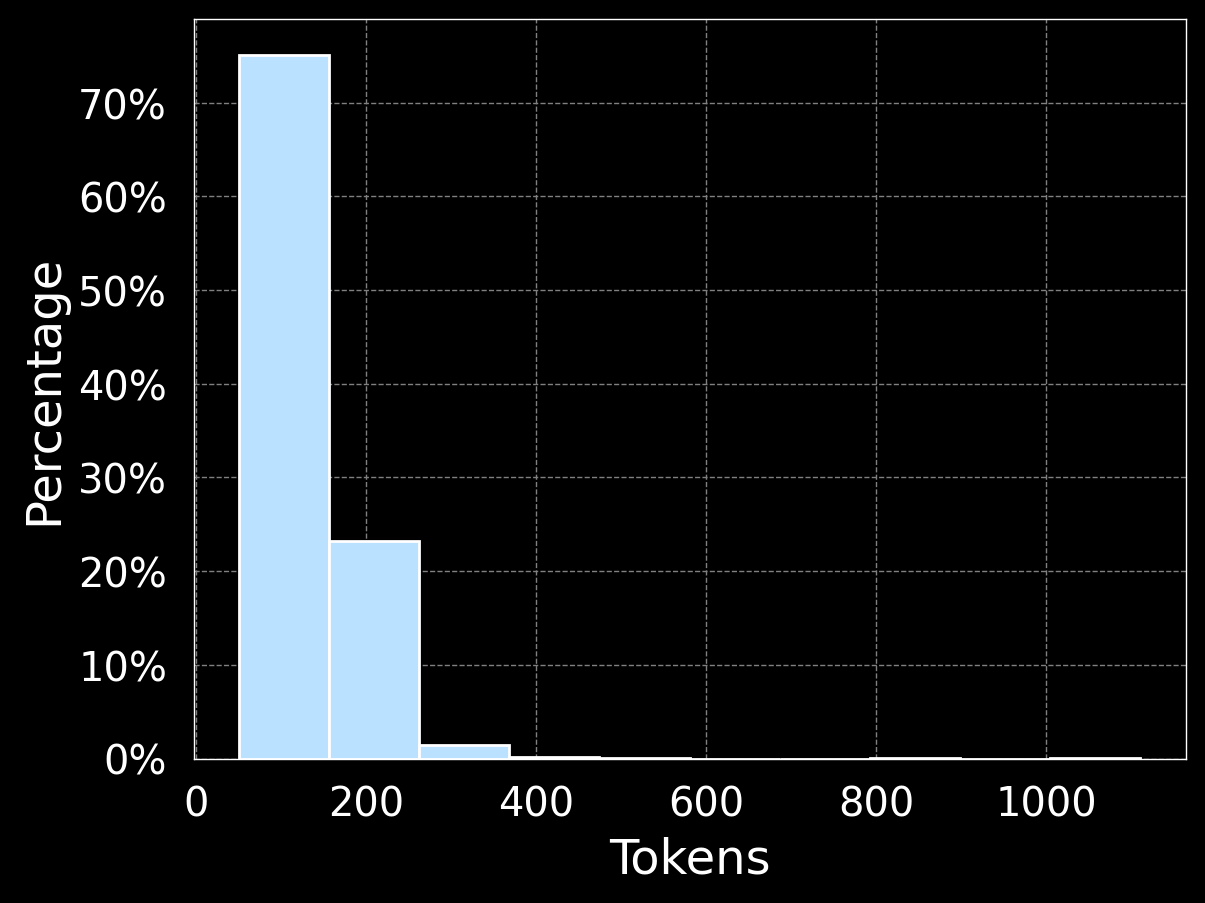

In [24]:
plt.hist(df.token_count, weights=np.ones(len(df.token_count)) / len(df.token_count))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Tokens")
plt.ylabel("Percentage")
plt.show();

In [25]:
len(df[df.token_count < 512]), len(df), len(df[df.token_count < 512]) / len(df)

(6997, 7000, 0.9995714285714286)

### Training

#### Create Train and Test dataset

In [26]:
df = df[df.token_count < 512]
df = df.sample(6000)
df.shape

(6000, 5)

In [27]:
train, temp = train_test_split(df, test_size=0.2)
val, test = train_test_split(temp, test_size=0.2)
len(train) / len(df), len(val) / len(df), len(test) / len(df)

(0.8, 0.16, 0.04)

In [28]:
len(train), len(val), len(test)

(4800, 960, 240)

In [29]:
train.sample(n=4000).to_json("train.json", orient="records", lines=True)
val.sample(n=500).to_json("val.json", orient="records", lines=True)
test.sample(n=100).to_json("test.json", orient="records", lines=True)

In [30]:
dataset = load_dataset(
    "json",
    data_files={"train": "train.json", "validation": "val.json", "test": "test.json"},
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [31]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'context', 'answer', 'text', 'token_count'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['question', 'context', 'answer', 'text', 'token_count'],
        num_rows: 500
    })
    test: Dataset({
        features: ['question', 'context', 'answer', 'text', 'token_count'],
        num_rows: 100
    })
})

In [32]:
print(dataset["train"][0]["text"])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 29 Sep 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

What is the impact of the new $1.25 price point on Dollar Tree’s sales units and profitability?

Information:

```
To date, the increase in the price point has more than offset the decline in the number of units sold.
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The increase to a $1.25 price point at Dollar Tree stores has more than offset the decline in the number of units sold, suggesting a positive impact on profitability.<|eot_id|>


#### create baseline outputs

In [33]:
### Test original model


pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=128,
    return_full_text=False,
)


def create_test_prompt(data_row):
    prompt = dedent(
        f"""
    {data_row["question"]}

    Information:

    ```
    {data_row["context"]}
    ```
    """
    )
    messages = [
        {
            "role": "system",
            "content": "Use only the information to answer the question",
        },
        {"role": "user", "content": prompt},
    ]
    return tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )



In [34]:
row = dataset["test"][0]
prompt = create_test_prompt(row)
print(prompt)


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 29 Sep 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

What are the operating segments of the company in Macao?

Information:

```
Our operating segments in Macao consist of The Venetian Macao; The Londoner Macao; The Parisian Macao; The Plaza Macao and Four Seasons Macao; and the Sands Macao.
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [35]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)



answer:     The operating segments in Macao consist of The Venetian Macao, The Londoner Macao, The Parisian Macao, The Plaza Macao and Four Seasons Macao, and the Sands Macao.
prediction: The operating segments of the company in Macao are:

1. The Venetian Macao
2. The Londoner Macao
3. The Parisian Macao
4. The Plaza Macao
5. Four Seasons Macao
6. Sands Macao

CPU times: user 3.04 s, sys: 208 ms, total: 3.25 s
Wall time: 4.22 s


In [36]:
row = dataset["test"][1]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 29 Sep 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

How much did the company's net earnings amount to in fiscal 2022?

Information:

```
Net earnings were $17.1 billion in fiscal 2022.
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [37]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)


answer:     $17.1 billion
prediction: The company's net earnings in fiscal 2022 were $17.1 billion.

CPU times: user 756 ms, sys: 3.08 ms, total: 759 ms
Wall time: 761 ms


In [38]:
row = dataset["test"][2]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 29 Sep 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

What is the interest rate applicable to draws under the Term Loan as mentioned?

Information:

```
Draws under the Term Loan bear interest on the principal amount outstanding at Term SOFR plus an applicable margin, currently 5.46%, plus a credit spread adjustment.
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [39]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)


answer:     5.46%
prediction: The interest rate applicable to draws under the Term Loan is 5.46% plus a credit spread adjustment.

CPU times: user 935 ms, sys: 3.83 ms, total: 938 ms
Wall time: 939 ms


In [40]:
rows = []
for row in tqdm(dataset["test"]):
    prompt = create_test_prompt(row)
    outputs = pipe(prompt)
    rows.append(
        {
            "question": row["question"],
            "context": row["context"],
            "prompt": prompt,
            "answer": row["answer"],
            "untrained_prediction": outputs[0]["generated_text"],
        }
    )

predictions_df = pd.DataFrame(rows)

100%|██████████| 100/100 [03:38<00:00,  2.19s/it]


#### Train on Completions

In [41]:
response_template = "<|end_header_id|>"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

examples = [dataset["train"][0]["text"]]
encodings = [tokenizer(e) for e in examples]

dataloader = DataLoader(encodings, collate_fn=collator, batch_size=1)

batch = next(iter(dataloader))
batch.keys()



dict_keys(['input_ids', 'attention_mask', 'labels'])

In [42]:
batch["labels"]

tensor([[  -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,    271,    791,   5376,    311,    264,    400,     16,
             13,    914,   3430,   1486,    520,  43464,   9119,  10756,    706,
            810,   1109,   4

#### LoRA Setup

In [ ]:
model

In [ ]:
lora_config = LoraConfig(
    r=32,
    lora_alpha=16,
    target_modules=[
        "self_attn.q_proj",
        "self_attn.k_proj",
        "self_attn.v_proj",
        "self_attn.o_proj",
        "mlp.gate_proj",
        "mlp.up_proj",
        "mlp.down_proj",
    ],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)


In [ ]:
model.print_trainable_parameters()

#### Train Loop

In [ ]:
OUTPUT_DIR = "experiments"

%load_ext tensorboard
%tensorboard --logdir "experiments/runs"

In [ ]:
sft_config = SFTConfig(
    output_dir=OUTPUT_DIR,
    dataset_text_field="text",
    max_seq_length=512,
    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    optim="paged_adamw_8bit",
    eval_strategy="steps",
    eval_steps=0.2,
    save_steps=0.2,
    logging_steps=10,
    learning_rate=1e-4,
    fp16=True,  # or bf16=True,
    save_strategy="steps",
    warmup_ratio=0.1,
    save_total_limit=2,
    lr_scheduler_type="constant",
    report_to="tensorboard",
    save_safetensors=True,
    dataset_kwargs={
        "add_special_tokens": False,  # We template with special tokens
        "append_concat_token": False,  # No need to add additional separator token
    },
    seed=SEED,
)

trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
)

In [ ]:
trainer.train()

In [ ]:
trainer.save_model(NEW_MODEL)

### Evaluation

#### Load Trained Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(NEW_MODEL)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto",
)

model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)
model = PeftModel.from_pretrained(model, NEW_MODEL)
model = model.merge_and_unload()

In [ ]:
!huggingface-cli login

In [ ]:
model.push_to_hub(NEW_MODEL, tokenizer=tokenizer, max_shard_size="5GB")
tokenizer.push_to_hub(NEW_MODEL)

#### Inference

In [43]:
dataset = load_dataset(
    "json",
    data_files={"train": "train.json", "validation": "val.json", "test": "test.json"},
)
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'context', 'answer', 'text', 'token_count'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['question', 'context', 'answer', 'text', 'token_count'],
        num_rows: 500
    })
    test: Dataset({
        features: ['question', 'context', 'answer', 'text', 'token_count'],
        num_rows: 100
    })
})

In [44]:
MODEL_NAME = "vasaicrow/Llama-3.2-1B-Instruct-Finance-RAG"
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, quantization_config=quantization_config, device_map="auto"
)

tokenizer_config.json:   0%|          | 0.00/54.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/926 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [45]:
pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=128,
    return_full_text=False,
)

In [46]:
row = dataset["test"][0]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 29 Sep 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

What are the operating segments of the company in Macao?

Information:

```
Our operating segments in Macao consist of The Venetian Macao; The Londoner Macao; The Parisian Macao; The Plaza Macao and Four Seasons Macao; and the Sands Macao.
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [47]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)


answer:     The operating segments in Macao consist of The Venetian Macao, The Londoner Macao, The Parisian Macao, The Plaza Macao and Four Seasons Macao, and the Sands Macao.
prediction: The operating segments of the company in Macao are The Venetian Macao, The Londoner Macao, The Parisian Macao, The Plaza Macao, and Four Seasons Macao, and the Sands Macao.

CPU times: user 2.85 s, sys: 11.8 ms, total: 2.86 s
Wall time: 3.99 s


In [48]:
row = dataset["test"][1]
prompt = create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 29 Sep 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

How much did the company's net earnings amount to in fiscal 2022?

Information:

```
Net earnings were $17.1 billion in fiscal 2022.
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [49]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)


answer:     $17.1 billion
prediction: $17.1 billion

CPU times: user 474 ms, sys: 3.85 ms, total: 478 ms
Wall time: 560 ms


In [50]:
row = dataset["test"][2]
prompt = create_test_prompt(row)
print(prompt)


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 29 Sep 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

What is the interest rate applicable to draws under the Term Loan as mentioned?

Information:

```
Draws under the Term Loan bear interest on the principal amount outstanding at Term SOFR plus an applicable margin, currently 5.46%, plus a credit spread adjustment.
```<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [51]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)


answer:     5.46%
prediction: 5.46%

CPU times: user 395 ms, sys: 2.84 ms, total: 398 ms
Wall time: 397 ms


In [ ]:
predictions = []
for row in tqdm(dataset["test"]):
    outputs = pipe(create_test_prompt(row))
    predictions.append(outputs[0]["generated_text"])


 69%|██████▉   | 69/100 [01:29<00:20,  1.48it/s]

In [ ]:
predictions_df["trained_prediction"] = predictions

In [ ]:
predictions_df.head()
predictions_df.to_csv("predictions.csv", index=None)
sample = predictions_df.sample(n=20)
sample.head()

#### Comparison

In [ ]:
for i, row in sample.head(n=10).reset_index().iterrows():
    print(f"{Fore.DARK_VIOLET_1A}{Back.WHITE}Example {i + 1}{Style.reset}")
    response = f"""
{Fore.BLUE}answer:{Style.reset} {row['answer']}

{Fore.GREEN}trained:{Style.reset} {row['trained_prediction']}

{Fore.DARK_ORANGE}untrained:{Style.reset} {row['untrained_prediction']}
"""
    print(response)
